## Машинное обучение 
### Факультет математики НИУ ВШЭ, 2019-20 учебный год

_Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев_

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2020)


## Домашнее задание 3. Метод k ближайших соседей

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

## О библиотеках
В задачах 1 и 2 вам предстоит написать функции, аналоги которых есть в библиотеке *scikit-learn* (`sklearn`). Реализовывать различные методы машинного обучения «с нуля» очень полезно: способность реализовать какой-то метод самому — это главный критерий того, что вы понимаете, как он работает. В то же время, разбираться в существующих библиотеках тоже полезно — именно с ними вам придётся столкнуться в любой практической работе. Поэтому мы рекомендуем решить эти задачи двумя способами: вручную и с помощью `sklearn`. За оба положены баллы (хотя за `sklearn` поменьше, потому что это проще).

## Задание 1 (4+1 баллов)

Вам предстоит реализовать две версии метода $k$ ближайших соседей (kNN) — обычный (который обсуждался на семинаре) и со взвешиванием.

В качестве метрики мы будем использовать $d_p(\cdot,\ \cdot)$ — [расстояние Минковского](https://en.wikipedia.org/wiki/Minkowski_distance) порядка $p$.



Пусть нам нужно вычислить значение $y$ для некоторого $x_{new}$, наши данные заданы как $\{x_i, y_i\}_{i=1}^l$. Обычный метод $k$ ближайших соседей находит такие $i_1, \ldots, i_k$, что $\{x_{i_m}\}_{m=1}^k$ являются $k$ ближайшими соседями для точки $x_{new}$ (по выбранной метрике $d_p(\cdot,\ \cdot)$), и полагает, что значение нового объекта:

$$\widehat{y} = \underset{c \in C}{\mathrm{argmax}}\ \sum_{m=1}^k[y_{i_m} = c],$$
где $C$ — множество классов, а $[y_{i_m}=c]$ — выражение, равное 1, если $y_{i_m}=c$, и 0 в противном случае. То есть $\widehat y$ — мода классов $k$ ближайших соседей. Модифицированный метод $k$ ближайших соседей, который вам предстоит реализовать, использует другую оценку:

$$\widehat y = \underset{c \in C}{\mathrm{argmax}} \sum_{i=1}^l w_{i}[y_i=c],$$
где вес $w_i$ вычисляется следующим образом:
$$w_{i}=\frac{1}{d_p(x_{new}, x_{i})}.$$

Таким образом, модифицированный метод присваивает $i$-му объекту вес $w_{i}$, уменьшающийся с увеличением расстояния до $x_{new}$, вместо того чтобы присваивать $k$ ближайшим соседям вес $1$, а остальным $0$.

---

Ниже предоставлен шаблон функции для реализации метода, который возвращает предсказания для тестовой выборки, используя взвешенный или обычный kNN (с возможностью выбора порядка $p$ метрики расстояния). Код для обычного kNN можно взять из семинара; если вы не были на семинаре — придётся написать самостоятельно.

---

За решение задачи вручную (только с использованием `numpy` и `scipy`) можно получить **до четырёх баллов**. Полный балл за эту часть ставится в том случае, если решение не использует циклы. За решение с циклами можно получить не больше **двух баллов** из четырёх.

За решение задачи с помощью `sklearn` можно получить **один балл**.

**Подсказка.** Вам придётся вычислить расстояние Минковского между $x_{new}$ и каждой из точек $x_i$, $i=1,\ldots, l$. Существует библиотечная функция, которая позволяет это сделать быстро и без циклов. Вам нужно найти её и использовать.

In [82]:
import scipy.spatial as sps
import scipy.stats as scs

In [258]:
def knn_classifier(x_train, y_train, x_test, k=1, distance='euclid', 
                   weight=True):
    """
    x_train is np.array with shape (l, d) (matrix with l rows, d columns)
    y_train is np.array with shape (l, ) (1-dimensional array with l elements)
    x_test is np.array with shape (n, d) (matrix with n rows, d columns)
    k is int (if weight is True, then the argument is ignored, else - number of neighbours)
    distance is int (order p of Minkowski distance) or str: 'euclidian', 'cityblock' (you can implement more options)
    weight is boolean, whether to use the weighted method or not

    return y_test, np.array with shape (n, ) (1-dimensional array with n elements)
    """
    ### SOLUTION BEGIN
    
    if type(distance) is str:
        dist_matrix = sps.distance.cdist(x_train, x_test, metric=distance)
    elif type(distance) is int:
        dist_matrix = sps.distance.cdist(x_train, x_test, metric="minkowski", p=distance)
        
    if weight:
        w_matrix = 1 / dist_matrix
        
        unique_classes = np.unique(y_train)
        unique_classes = np.reshape(unique_classes, (unique_classes.shape[0], 1))
        
        def char_builder(shape, ind):
            tmp = np.zeros(shape)
            tmp[ind] = 1
            return tmp
        
        char_matrix = np.apply_along_axis(lambda v : char_builder(x_train.shape[0], np.nonzero(y_train == v[0])), 1, unique_classes)
        
        class_score = char_matrix @ w_matrix
        
        class_indexes = np.argmax(class_score, 0)
        
        return unique_classes[class_indexes].T[0]
    
    else:
        index_sorted = np.argsort(dist_matrix, axis=0)
        
        return scs.mode(y_train[index_sorted[:k]])[0][0]

    ### SOLUTION END

## Задание 2 (2 + 0.5 баллов)

На семинаре было рассказано про разные виды кросс-валидации. В этом задании вам предстоит реализовать собственноручно k-fold cross validation со стратификацией по параметру $y$ (целевой категориальной переменной).

Ниже предоставлен шаблон функции, которая делит данные на $K$ частей («фолдов»), каждая из которых имеет то же (или максимально близкое) распределение классов (то есть значений переменной $y$), что и целый датасет. Она должна вернуть $K$-элементный список, каждый элемент которого является четырёхэлементным кортежем: `(x_train, y_train, x_test, y_test)`, где `x_test, y_test` соответствует содержимому одного из фолдов, а `x_train, y_train` — всему остальному датасету. Если вы знаете, что такое генераторы, вместо того, чтобы возвращать $K$-элементный список, можете сделать соответствующий генератор.

Ниже есть код, который поможет вам себя проверить.

---

За решение задачи вручную ставится **2 балла** максимум. В задаче можно использовать циклы, однако следует помнить, что циклы в питоне — медленные, и при любой возможности следует использовать векторизованные функции `numpy`. За неоптимальное использование циклов оценка может быть снижена.

За решение задачи с помощью `sklearn` ставится **0.5 балла**.

In [358]:
def strat_kfold_gen(x, y, k):
    '''
    x is np.array with shape (l, d) (matrix with l rows, d columns)
    y is np.array with shape (l, ) (1-dimensional array with l elements)
    k is int, number of folds to split data

    returns x_train, y_train, x_test, y_test
    '''
    ### SOLUTION BEGIN

    permutation = np.random.permutation(y.shape[0])
    
    x_permutated = x[permutation]
    y_permutated = y[permutation]
    
    x_per_split = np.array_split(x_permutated, k)
    y_per_split = np.array_split(y_permutated, k)
    
    ret = list()
    
    for i in range(len(y_per_split)):
        if i == 0:
            ret.append((np.concatenate(x_per_split[1:]), np.concatenate(y_per_split[1:]), x_per_split[0], y_per_split[0]))
        elif i == y.shape[0] - 1:
            ret.append((np.concatenate(x_per_split[:-1]), np.concatenate(y_per_split[:-1]), x_per_split[i], y_per_split[i]))
        else:
            ret.append((np.concatenate(x_per_split[:i] + x_per_split[(i + 1):]), np.concatenate(y_per_split[:i] + y_per_split[(i+1):]), x_per_split[i], y_per_split[i]))
        
    return ret
    
    ### SOLUTION END

In [359]:
# CHECK YOURSELF

x = np.random.normal(size=(171, 3))
y = np.hstack([np.ones(101), np.ones(50) * 2, np.ones(20) * 3])
np.random.shuffle(y)
K = 5

s = '\nClass distribution train/test:'
t = '1 - {:.3f}\t2 - {:.3f}\t3 - {:.3f}'
print(f'ALL, length={len(y)}', 
      s, '\n\tALL:  ', t.format(*np.unique(y, return_counts=True)[1] / len(y)))
print('-'*70)
for i, (_, y_tr, _, y_t) in enumerate(strat_kfold_gen(x, y, K)):
    print(f'FOLD #{i+1}, length={len(y_tr)}/{len(y_t)}', 
          s, '\n\tTRAIN: ', t.format(*np.unique(y_tr, return_counts=True)[1] / len(y_tr)), 
             '\n\tTEST:  ', t.format(*np.unique(y_t, return_counts=True)[1] / len(y_t)))

ALL, length=171 
Class distribution train/test: 
	ALL:   1 - 0.591	2 - 0.292	3 - 0.117
----------------------------------------------------------------------
FOLD #1, length=136/35 
Class distribution train/test: 
	TRAIN:  1 - 0.625	2 - 0.272	3 - 0.103 
	TEST:   1 - 0.457	2 - 0.371	3 - 0.171
FOLD #2, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.606	2 - 0.270	3 - 0.124 
	TEST:   1 - 0.529	2 - 0.382	3 - 0.088
FOLD #3, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.562	2 - 0.314	3 - 0.124 
	TEST:   1 - 0.706	2 - 0.206	3 - 0.088
FOLD #4, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #5, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.569	2 - 0.314	3 - 0.117 
	TEST:   1 - 0.676	2 - 0.206	3 - 0.118


## Задание 3.1 (3 балла)

Теперь наконец применим наши две функции и посмотрим подробнее на результаты. Рассмотрим датасет [Thyroid Gland](https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.names), состоящий из результатов различных  анализов, связанных со щитовидной железой пациентов. Целевой переменной является состояние щитовидной железы: нормальное, гипотиреоз или гипертиреоз.

**1. (0.5 балла)** Скачайте датасет (https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv) и ответьте на следующие вопросы. Сколько у датасета строк и столбцов? Целевая переменная записана последним столбцом. Какое у неё распределение? (Постройте подходящую картинку.)

**Замечание.** Функция `pd.read_csv` по умолчанию считает, что названия столбцов указаны в первой строке файла, но в файле по ссылке названия столбцов не указаны. Прочитайте в документации, как сделать так, чтобы `pd.read_csv` не воспринимала первую строчку файла как названия столбцов.

In [360]:
! wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv

--2020-03-04 22:15:39--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4843 (4.7K) [text/plain]
Saving to: ‘new-thyroid.csv’

new-thyroid.csv     100%[===================>]   4.73K  --.-KB/s    in 0s      

2020-03-04 22:15:40 (60.6 MB/s) - ‘new-thyroid.csv’ saved [4843/4843]



In [361]:
# YOUR CODE
df = pd.read_csv('./new-thyroid.csv', header=None)

In [362]:
df

,0,1,2,3,4,5
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1
...,...,...,...,...,...,...
210,118,6.5,1.3,1.7,11.5,3
211,139,4.2,0.7,4.3,6.3,3
212,103,5.1,1.4,1.2,5.0,3
213,97,4.7,1.1,2.1,12.6,3


In [373]:
df_last = df[df.columns[5]]

In [374]:
df_last

0      1
1      1
2      1
3      1
4      1
      ..
210    3
211    3
212    3
213    3
214    3
Name: 5, Length: 215, dtype: int64

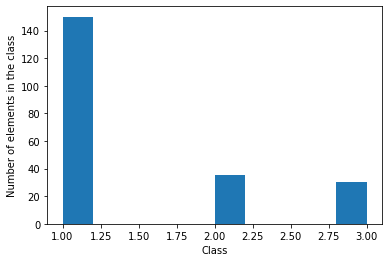

In [377]:
plt.hist(df_last)
plt.xlabel("Class")
plt.ylabel("Number of elements in the class")
plt.show()

In [378]:
df_last.describe()

count    215.000000
mean       1.441860
std        0.726737
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: 5, dtype: float64

**2. (2 балла)** Примените ваш kNN-алгоритм для предсказания значения целевой переменной, используя кросс-валидацию на 3 фолдах. (Вам нужно изготовить из датафрейма массивы numpy `x` и `y`, которые можно скормить функциям, написанным в задачах 1 и 2. Чтобы получить массив из датафрейма можно использовать свойство `.values`.) Перебирая значения параметра $k$ — количества ближайших соседей — от 0 до 20 нарисуйте два графика зависимости качества предсказания (будем использовать accuracy) от $k$ — один для обучающей и один для тестовой выборок. Можно рисовать отдельную линию на графике для каждого фолда, либо рисовать их среднее±разброс.

In [380]:
# YOUR CODE
df_data = df[df.columns[:5]]

In [381]:
df_data

,0,1,2,3,4
0,107,10.1,2.2,0.9,2.7
1,113,9.9,3.1,2.0,5.9
2,127,12.9,2.4,1.4,0.6
3,109,5.3,1.6,1.4,1.5
4,105,7.3,1.5,1.5,-0.1
...,...,...,...,...,...
210,118,6.5,1.3,1.7,11.5
211,139,4.2,0.7,4.3,6.3
212,103,5.1,1.4,1.2,5.0
213,97,4.7,1.1,2.1,12.6


In [382]:
df_y = df_last.values
df_x = df_data.values

In [383]:
K_folds = strat_kfold_gen(df_x, df_y, 3)

In [385]:
import sklearn.metrics as skm

In [390]:
skm.accuracy_score(K_folds[0][3], knn_classifier(K_folds[0][0], K_folds[0][1], K_folds[0][2], weight=False, k=5))

0.875

In [405]:
first_fold = list()
second_fold = list()
third_fold = list()

In [406]:
print("First fold accuracy")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[0][3], knn_classifier(K_folds[0][0], K_folds[0][1], K_folds[0][2], weight=False, k=i))
    first_fold.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

First fold accuracy
Accurace with 1 neighbors: 0.9166666666666666
Accurace with 2 neighbors: 0.875
Accurace with 3 neighbors: 0.9027777777777778
Accurace with 4 neighbors: 0.875
Accurace with 5 neighbors: 0.875
Accurace with 6 neighbors: 0.875
Accurace with 7 neighbors: 0.875
Accurace with 8 neighbors: 0.8472222222222222
Accurace with 9 neighbors: 0.8472222222222222
Accurace with 10 neighbors: 0.8194444444444444
Accurace with 11 neighbors: 0.8194444444444444
Accurace with 12 neighbors: 0.7916666666666666
Accurace with 13 neighbors: 0.7916666666666666
Accurace with 14 neighbors: 0.7777777777777778
Accurace with 15 neighbors: 0.7916666666666666
Accurace with 16 neighbors: 0.7777777777777778
Accurace with 17 neighbors: 0.7777777777777778
Accurace with 18 neighbors: 0.7361111111111112
Accurace with 19 neighbors: 0.7361111111111112
Accurace with 20 neighbors: 0.7222222222222222


In [407]:
print("Second fold accuracy")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[1][3], knn_classifier(K_folds[1][0], K_folds[0][1], K_folds[1][2], weight=False, k=i))
    second_fold.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

Second fold accuracy
Accurace with 1 neighbors: 0.6944444444444444
Accurace with 2 neighbors: 0.75
Accurace with 3 neighbors: 0.7916666666666666
Accurace with 4 neighbors: 0.8055555555555556
Accurace with 5 neighbors: 0.8055555555555556
Accurace with 6 neighbors: 0.8055555555555556
Accurace with 7 neighbors: 0.8333333333333334
Accurace with 8 neighbors: 0.8194444444444444
Accurace with 9 neighbors: 0.8333333333333334
Accurace with 10 neighbors: 0.8194444444444444
Accurace with 11 neighbors: 0.8472222222222222
Accurace with 12 neighbors: 0.8055555555555556
Accurace with 13 neighbors: 0.8055555555555556
Accurace with 14 neighbors: 0.7916666666666666
Accurace with 15 neighbors: 0.7777777777777778
Accurace with 16 neighbors: 0.7916666666666666
Accurace with 17 neighbors: 0.7083333333333334
Accurace with 18 neighbors: 0.7083333333333334
Accurace with 19 neighbors: 0.7083333333333334
Accurace with 20 neighbors: 0.7083333333333334


In [408]:
print("Third fold accuracy")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[2][3], knn_classifier(K_folds[2][0], K_folds[2][1], K_folds[2][2], weight=False, k=i))
    third_fold.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

Third fold accuracy
Accurace with 1 neighbors: 0.9295774647887324
Accurace with 2 neighbors: 0.8873239436619719
Accurace with 3 neighbors: 0.9014084507042254
Accurace with 4 neighbors: 0.8873239436619719
Accurace with 5 neighbors: 0.9014084507042254
Accurace with 6 neighbors: 0.8873239436619719
Accurace with 7 neighbors: 0.8873239436619719
Accurace with 8 neighbors: 0.8732394366197183
Accurace with 9 neighbors: 0.8873239436619719
Accurace with 10 neighbors: 0.8732394366197183
Accurace with 11 neighbors: 0.8732394366197183
Accurace with 12 neighbors: 0.8591549295774648
Accurace with 13 neighbors: 0.8591549295774648
Accurace with 14 neighbors: 0.8591549295774648
Accurace with 15 neighbors: 0.8591549295774648
Accurace with 16 neighbors: 0.8591549295774648
Accurace with 17 neighbors: 0.8591549295774648
Accurace with 18 neighbors: 0.8591549295774648
Accurace with 19 neighbors: 0.8591549295774648
Accurace with 20 neighbors: 0.8591549295774648


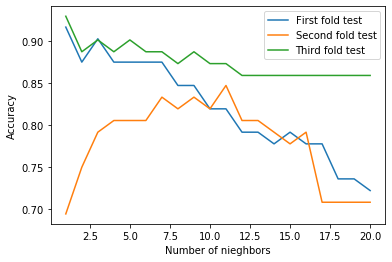

In [413]:
plt.plot(np.linspace(1, 20, 20), first_fold, label="First fold test")
plt.plot(np.linspace(1, 20, 20), second_fold, label="Second fold test")
plt.plot(np.linspace(1, 20, 20), third_fold, label="Third fold test")
plt.legend(loc="best")
plt.xlabel("Number of nieghbors")
plt.ylabel("Accuracy")
plt.show()

In [417]:
first_fold_train = list()
second_fold_train = list()
third_fold_train = list()

In [418]:
print("First fold accuracy (train)")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[0][1], knn_classifier(K_folds[0][0], K_folds[0][1], K_folds[0][0], weight=False, k=i))
    first_fold_train.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

First fold accuracy (train)
Accurace with 1 neighbors: 1.0
Accurace with 2 neighbors: 0.951048951048951
Accurace with 3 neighbors: 0.958041958041958
Accurace with 4 neighbors: 0.9230769230769231
Accurace with 5 neighbors: 0.9440559440559441
Accurace with 6 neighbors: 0.9090909090909091
Accurace with 7 neighbors: 0.9230769230769231
Accurace with 8 neighbors: 0.8881118881118881
Accurace with 9 neighbors: 0.8881118881118881
Accurace with 10 neighbors: 0.8881118881118881
Accurace with 11 neighbors: 0.8881118881118881
Accurace with 12 neighbors: 0.8741258741258742
Accurace with 13 neighbors: 0.8811188811188811
Accurace with 14 neighbors: 0.8601398601398601
Accurace with 15 neighbors: 0.8601398601398601
Accurace with 16 neighbors: 0.8601398601398601
Accurace with 17 neighbors: 0.8601398601398601
Accurace with 18 neighbors: 0.8531468531468531
Accurace with 19 neighbors: 0.8531468531468531
Accurace with 20 neighbors: 0.8531468531468531


In [419]:
print("Second fold accuracy (train)")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[1][1], knn_classifier(K_folds[1][0], K_folds[1][1], K_folds[1][0], weight=False, k=i))
    second_fold_train.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

Second fold accuracy (train)
Accurace with 1 neighbors: 1.0
Accurace with 2 neighbors: 0.972027972027972
Accurace with 3 neighbors: 0.986013986013986
Accurace with 4 neighbors: 0.9300699300699301
Accurace with 5 neighbors: 0.9300699300699301
Accurace with 6 neighbors: 0.916083916083916
Accurace with 7 neighbors: 0.9230769230769231
Accurace with 8 neighbors: 0.8881118881118881
Accurace with 9 neighbors: 0.8881118881118881
Accurace with 10 neighbors: 0.8741258741258742
Accurace with 11 neighbors: 0.8811188811188811
Accurace with 12 neighbors: 0.8601398601398601
Accurace with 13 neighbors: 0.8671328671328671
Accurace with 14 neighbors: 0.8531468531468531
Accurace with 15 neighbors: 0.8601398601398601
Accurace with 16 neighbors: 0.8461538461538461
Accurace with 17 neighbors: 0.8531468531468531
Accurace with 18 neighbors: 0.8391608391608392
Accurace with 19 neighbors: 0.8391608391608392
Accurace with 20 neighbors: 0.8181818181818182


In [420]:
print("Third fold accuracy (train)")

for i in range(1, 21):
    acc = skm.accuracy_score(K_folds[2][1], knn_classifier(K_folds[2][0], K_folds[2][1], K_folds[2][0], weight=False, k=i))
    third_fold_train.append(acc)
    print("Accurace with " + str(i) + " neighbors: " + str(acc))

Third fold accuracy (train)
Accurace with 1 neighbors: 1.0
Accurace with 2 neighbors: 0.9513888888888888
Accurace with 3 neighbors: 0.9583333333333334
Accurace with 4 neighbors: 0.9513888888888888
Accurace with 5 neighbors: 0.9513888888888888
Accurace with 6 neighbors: 0.9444444444444444
Accurace with 7 neighbors: 0.9444444444444444
Accurace with 8 neighbors: 0.9305555555555556
Accurace with 9 neighbors: 0.9305555555555556
Accurace with 10 neighbors: 0.9097222222222222
Accurace with 11 neighbors: 0.9166666666666666
Accurace with 12 neighbors: 0.8958333333333334
Accurace with 13 neighbors: 0.8958333333333334
Accurace with 14 neighbors: 0.8888888888888888
Accurace with 15 neighbors: 0.8888888888888888
Accurace with 16 neighbors: 0.8819444444444444
Accurace with 17 neighbors: 0.8888888888888888
Accurace with 18 neighbors: 0.8611111111111112
Accurace with 19 neighbors: 0.8541666666666666
Accurace with 20 neighbors: 0.8472222222222222


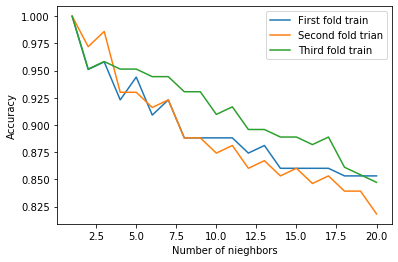

In [421]:
plt.plot(np.linspace(1, 20, 20), first_fold_train, label="First fold train")
plt.plot(np.linspace(1, 20, 20), second_fold_train, label="Second fold trian")
plt.plot(np.linspace(1, 20, 20), third_fold_train, label="Third fold train")
plt.legend(loc="best")
plt.xlabel("Number of nieghbors")
plt.ylabel("Accuracy")
plt.show()

Как зависит качество от значения $k$ для каждой выборки? Как выбрать оптимальное значение? 

*Ваш ответ:* На тестовой выборки видно, что оптимальное количество соседей без нормировки от 1 до 5.

**3. (0.5 балла)** Попробуйте улучшить качество модели, отмасштабировав данные таким образом, чтобы разброс значений всех переменных был примерно одинаковым (способ скейлинга на ваш выбор, см. модуль [sklearn-preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)). 

In [8]:
# YOUR CODE

Какие изменения в качестве произошли?

*Ваш ответ:* ...

## Задание 3.2 (3 балла)
Теперь рассмотрим другой [датасет](https://archive.ics.uci.edu/ml/datasets/Wine), являющийся результатом химического анализа вина. 

**1. (0.5 балла)** Загрузите датасет, выведите его размерности и распределение классов. Отмасштабируйте данные как и в предыдущем пункте.

In [1]:
### SOLUTION

Наша итоговая цель в этом задании — нарисовать объекты датасета на плоскости и посмотреть, как алгоритм делит плоскость на классы и как это влияет на результаты на тестовой выборке. Кроме этого мы рассмотрим разные параметры алгоритма. Первая проблема состоит в том, что в датасете больше двух признаков — непонятно, как объекты изображать на плоскости. Обычно в такой ситуации используются методы снижения размерности (например, PCA), но мы про них ещё не говорили, поэтому воспользуемся другим подходом: попробуем выделить среди признаков те, которые (по одиночке) дают максимум информации о значении целевой переменной (это называется univariate feature selection).

**2. (0.5 балла)**  Функция `sklearn.feature_selection.mutual_info_classif` находит *взаимную информацию* между целевой переменной и каждым из признаков. Чем больше взаимная информация, тем больше знание одной переменной сообщает нам о возможных значениях другой переменной. С помощью этой функции выберите два признака, которые имеют максимальную взаимную информацию с целевой переменной. Создайте из них numpy-массив $X$ и создайте массив $y$ со значениями целевой переменной. После чего разделите данные на обучающую и тестовую выборки в соотношении 2:1, воспользовавшись вашей функцией `strat_kfold_gen` и взяв только один элемент из возвращённого списка (или генератора).

In [11]:
# YOUR CODE

В следующем задании вопользуйтесь примерами из интернета ([[1]](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html), [[2]](https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib), [[3]](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/tutorial/plot_knn_iris.html) и т.д. на ваш выбор), чтобы построить график следующего типа. Каждая точка плоскости (decision boundaries) покрашена в свой цвет в зависимости от того, какое предсказание сделает алгоритм для этой точки, а объекты раскрашены в тот цвет, какой у них истинный $y$.

![example.png](example.png)

**3. (2 балла)** Переберите $M$ значений параметра $k$ (можете добавить значение 0 как индикатор использования взвешенного kNN), $L$ значений параметра $p$ (порядок расстояния Минковского) и постройте сетку $L \times M$  графиков типа выше. ($M$ и $L$ — небольшие целые числа, больше 3.)

На графиках должны быть:

- подпись: набор параметров и качество (accuracy) до третьего знака после запятой;
- окрашенные в цвет истинного класса точки обучающей и тестовой выборки
    - сделайте маркеры обучающей и тестовой выборок различными (например, треугольники и кружочки/черная и белая обводка/маленький и большой размер);
- границы принятия решений (decision boundaries) на основе обученного (на обучающей выборке) алгоритма kNN;
- общее название сетки графиков, где в том числе указаны номера признаков, выбранные в предыдущем пункте.

In [13]:
# YOUR CODE

У какого набора параметров получилось лучшее качество?

Объясните как параметры влияют на decision boundaries.

*Ваш ответ: ...*